# Step by step analysis of the VisCoIN results

In [1]:
import os 
import pandas as pd
import re
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision import transforms
from viscoin.models.classifiers import Classifier
from viscoin.models.concept_extractors import ConceptExtractor
from viscoin.models.explainers import Explainer
from viscoin.models.gan import GeneratorAdapted
from viscoin.testing.viscoin import AmplifiedConceptsResults
from viscoin.testing.viscoin import amplify_concepts
from viscoin.testing.viscoin import plot_amplified_images
from viscoin.testing.classifiers import test_classifier
#from train_classifier_custom import load_datasets, create_dataloaders
from viscoin.datasets.custom_local_dataset import CustomImageDataset, load_datasets, create_dataloaders
from viscoin.testing.concepts import test_concepts

## 1. Load the trained VisCoIN model

In [2]:
viscoin_path =  "/home/ids/fabre-24/viscoin/VisCoIN/checkpoints/viscoin_64/exp_349317/viscoin_final_64_mapping.pth"

In [3]:
checkpoint = torch.load(viscoin_path, map_location='cpu')  # or 'cuda' if using GPU
print(checkpoint.keys())

dict_keys(['classifier', 'concept_extractor', 'explainer', 'gan'])


In [6]:
adapted_gan_config = {
    "coarse_layer": 4,
    "mid_layer": 12,
    "num_layers": 1,
}

N_CONCEPTS = 64

classifier = Classifier(output_classes=9)
concept_extractor = ConceptExtractor(n_concepts=N_CONCEPTS)
explainer = Explainer(n_concepts=N_CONCEPTS, n_classes=9)
gan = GeneratorAdapted(
    z_dim=N_CONCEPTS,  # number of concepts
    c_dim=0,
    w_dim=512,
    img_resolution=256,
    img_channels=3,
    synthesis_kwargs={
        "channel_base": 16384,
        "channel_max": 512,
    }
)

In [7]:
classifier.load_state_dict(checkpoint['classifier'])

concept_extractor.load_state_dict(checkpoint['concept_extractor'])

explainer.load_state_dict(checkpoint['explainer'])

gan.load_state_dict(checkpoint['gan'])

<All keys matched successfully>

## 2. Plot train and test losses

In [8]:
log_file_path = "/home/ids/fabre-24/viscoin/VisCoIN/checkpoints/viscoin_64/exp_349317/train_viscoin_64_mapping349317.err"

In [18]:
# extract info from log file
with open(log_file_path, "r", encoding="utf-8") as file:
    log_text = file.read()

    
# Regex patterns for Training and Testing logs
train_pattern = re.compile(
    #r"(?P<step>\d{4,5})/100000.*?"
    r"(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+) - .*?TrainingResults\("
    r"acc_loss=(?P<acc_loss>[\d\.eE+-]+), cr_loss=(?P<cr_loss>[\d\.eE+-]+), "
    r"of_loss=(?P<of_loss>[\d\.eE+-]+), ortho_loss=(?P<ortho_loss>[\d\.eE+-]+), "
    r"rec_loss=(?P<rec_loss>[\d\.eE+-]+), gan_loss=(?P<gan_loss>[\d\.eE+-]+), "
    r"inter_loss=(?P<inter_loss>[\d\.eE+-]+)"
)

test_pattern = re.compile(
    r"(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+) - .*?TestingResults\("
    r"acc_loss=np\.float64\((?P<acc_loss>[\d\.eE+-]+)\), cr_loss=np\.float64\((?P<cr_loss>[\d\.eE+-]+)\), "
    r"of_loss=np\.float64\((?P<of_loss>[\d\.eE+-]+)\), lp_loss=np\.float64\((?P<lp_loss>[\d\.eE+-]+)\), "
    r"rec_loss_l1=np\.float64\((?P<rec_loss_l1>[\d\.eE+-]+)\), rec_loss_l2=np\.float64\((?P<rec_loss_l2>[\d\.eE+-]+)\), "
    r"preds_overlap=np\.float64\((?P<preds_overlap>[\d\.eE+-]+)\), correct_preds=np\.float64\((?P<correct_preds>[\d\.eE+-]+)\), "
    r"correct_expl_preds=np\.float64\((?P<correct_expl_preds>[\d\.eE+-]+)\), fid_score=np\.float64\((?P<fid_score>[\d\.eE+-]+)\)"
)

faithfulness_pattern = re.compile(
    r"mean\s*=\s*(?P<mean>[\d\.eE+-]+)\s*---\s*std\s*=\s*(?P<std>[\d\.eE+-]+)"
)


steps_pattern = re.compile(
    r"(?P<step>\d{4,5})/100000"
)

# Extract all training and testing matches
train_matches = train_pattern.finditer(log_text)
test_matches = test_pattern.finditer(log_text)
faith_matches = faithfulness_pattern.finditer(log_text)
steps_matches = steps_pattern.finditer(log_text)

# Convert matches into DataFrames
train_data = [m.groupdict() for m in train_matches]
test_data = [m.groupdict() for m in test_matches]
faith_data = [m.groupdict() for m in faith_matches]
steps_col = [m.groupdict() for m in steps_matches]

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
df_faith = pd.DataFrame(faith_data)
df_steps = pd.DataFrame(steps_col)

# Convert numerical fields to float
for df in [df_train, df_test, df_faith, df_steps]:
    for col in df.columns:
        if col != 'timestamp':
            df[col] = df[col].astype(float)

In [19]:
df_train.insert(0, "step", range(0, 100000, 2000))
df_test.insert(0, "step", range(0, 100000, 2000))
df_faith.insert(0, "step", range(25000, 100000, 25000))

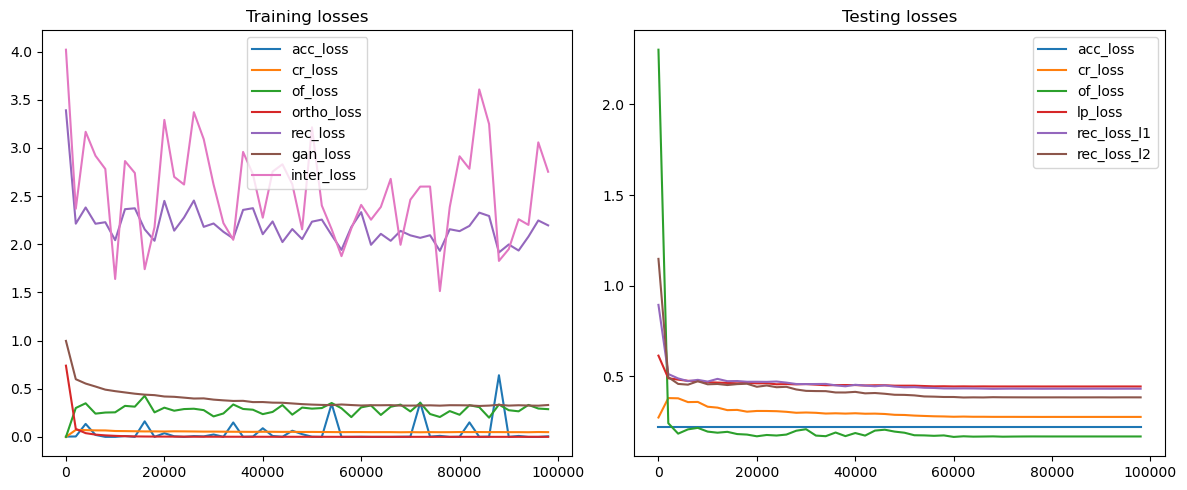

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

axs[0].plot(df_train['step'], df_train['acc_loss'], label='acc_loss')
axs[0].plot(df_train['step'], df_train['cr_loss'], label='cr_loss')
axs[0].plot(df_train['step'], df_train['of_loss'], label='of_loss')
axs[0].plot(df_train['step'], df_train['ortho_loss'], label='ortho_loss')
axs[0].plot(df_train['step'], df_train['rec_loss'], label='rec_loss')
axs[0].plot(df_train['step'], df_train['gan_loss'], label='gan_loss')
axs[0].plot(df_train['step'], df_train['inter_loss'], label='inter_loss')
axs[0].set_title("Training losses")
axs[0].legend()

axs[1].plot(df_test['step'], df_test['acc_loss'], label='acc_loss')
axs[1].plot(df_test['step'], df_test['cr_loss'], label='cr_loss')
axs[1].plot(df_test['step'], df_test['of_loss'], label='of_loss')
axs[1].plot(df_test['step'], df_test['lp_loss'], label='lp_loss')
axs[1].plot(df_test['step'], df_test['rec_loss_l1'], label='rec_loss_l1')
axs[1].plot(df_test['step'], df_test['rec_loss_l2'], label='rec_loss_l2')
axs[1].set_title("Testing losses")
axs[1].legend()


plt.tight_layout()
plt.show()

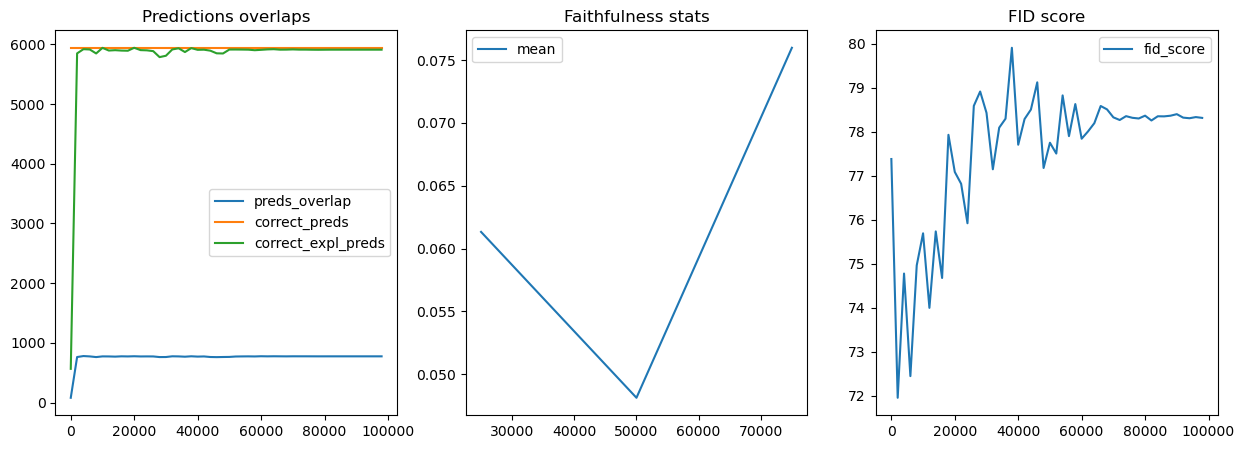

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  

axs[0].plot(df_test['step'], df_test['preds_overlap'], label='preds_overlap')
axs[0].plot(df_test['step'], df_test['correct_preds'], label='correct_preds')
axs[0].plot(df_test['step'], df_test['correct_expl_preds'], label='correct_expl_preds')
axs[0].set_title("Predictions overlaps")
axs[0].legend()

axs[1].plot(df_faith['step'], df_faith['mean'], label='mean')
#axs[1].plot(df_faith['step'], df_faith['std'], label='std')
axs[1].set_title("Faithfulness stats")# (probability of best concept after reconstruction)")
axs[1].legend()

axs[2].plot(df_test['step'], df_test['fid_score'], label='fid_score')
axs[2].set_title("FID score")
axs[2].legend()

plt.show()


## 3. Test accuracy of the trained VisCoIN model

In [22]:
# test accuracy of obtained VisCoIN model

DATASET_PATH = "/home/ids/fabre-24/viscoin/datasets/1aurent_nct-crc-he"
RESIZED_PATH = os.path.join(DATASET_PATH, "resized_images_256")
TARGET_SPLITS = ["NCT_CRC_HE_100K", "CRC_VAL_HE_7K"]
BATCH_SIZE = 32

train_dataset, test_dataset = load_datasets(RESIZED_PATH, TARGET_SPLITS)

_, test_loader = create_dataloaders(train_dataset, test_dataset, BATCH_SIZE)


device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = classifier.to(device)
concept_extractor = concept_extractor.to(device)
explainer = explainer.to(device)

#criterion = nn.CrossEntropyLoss()

#accuracy, mean_loss = test_classifier(classifier, test_loader, device, criterion, False)

results = test_concepts(classifier, concept_extractor, explainer, test_loader, device)


Concept test batches: 100%|██████████████████████████████████████████████████████████████████████████████████████| 225/225 [02:13<00:00,  1.69it/s]
/home/ids/fabre-24/viscoin/VisCoIN/viscoin/utils/maths.py:13: RuntimeWarning: invalid value encountered in divide
  return (arr - min) / (max - min)


In [23]:
print(results)

ConceptTestResults(classifier_accuracy=0.9318981481481481, explainer_accuracy=0.9269907407407408, concept_activation_per_image=array([0.        , 0.01681639, 0.04137328, 0.07438095, 0.09741598,
       0.11465566, 0.13308847, 0.14833791, 0.16358515, 0.17807181,
       0.19008002, 0.20103884, 0.21243077, 0.22319923, 0.23319244,
       0.24296937, 0.25277343, 0.26156788, 0.27009426, 0.27799567,
       0.28578103, 0.29331731, 0.30120216, 0.30960979, 0.31763525,
       0.32572518, 0.33432831, 0.3426153 , 0.35124604, 0.35980456,
       0.36809538, 0.37641958, 0.38445759, 0.39252546, 0.40062413,
       0.40930604, 0.41831649, 0.4275258 , 0.43708829, 0.44719668,
       0.45794442, 0.4696291 , 0.48224667, 0.49570437, 0.50898134,
       0.52348331, 0.53818678, 0.55301302, 0.56827904, 0.5835801 ,
       0.59940537, 0.61552869, 0.63335939, 0.64931093, 0.66538526,
       0.68241704, 0.70171857, 0.7247151 , 0.75024633, 0.77657374,
       0.81015214, 0.84577544, 0.88773234, 1.        ]), concept_acti

## 4. Visualise concept activation on the NCT-CRC-HE dataset

In [24]:
# Load your image
image_path3 = "/home/ids/fabre-24/viscoin/datasets/1aurent_nct-crc-he/resized_images_256/CRC_VAL_HE_7K/3/image_2218.png"
image3 = Image.open(image_path3).convert("RGB")

# Resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts to (C, H, W) and scales to [0, 1]
])

image_tensor3 = transform(image3)


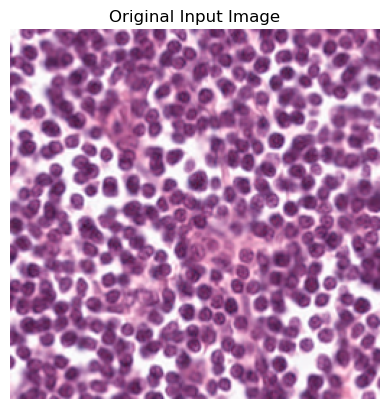

In [25]:
image_tensor = image_tensor3

# Assume image_tensor is your (3, H, W) input image
plt.imshow(TF.to_pil_image(image_tensor))
plt.title("Original Input Image")
plt.axis("off")
plt.show()

In [26]:
concept_selection = {
    "method": "threshold",
    "threshold": 0.7
}

In [27]:
#concept_selection = {
#    "method": "top_k",
#    "k": 5
#}

In [28]:

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier.to(device)
concept_extractor.to(device)
explainer.to(device)
gan.to(device)

results = amplify_concepts(
    image=image_tensor,
    classifier=classifier,
    concept_extractor=concept_extractor,
    explainer=explainer,
    generator=gan,
    concept_selection=concept_selection,
    device=device
)

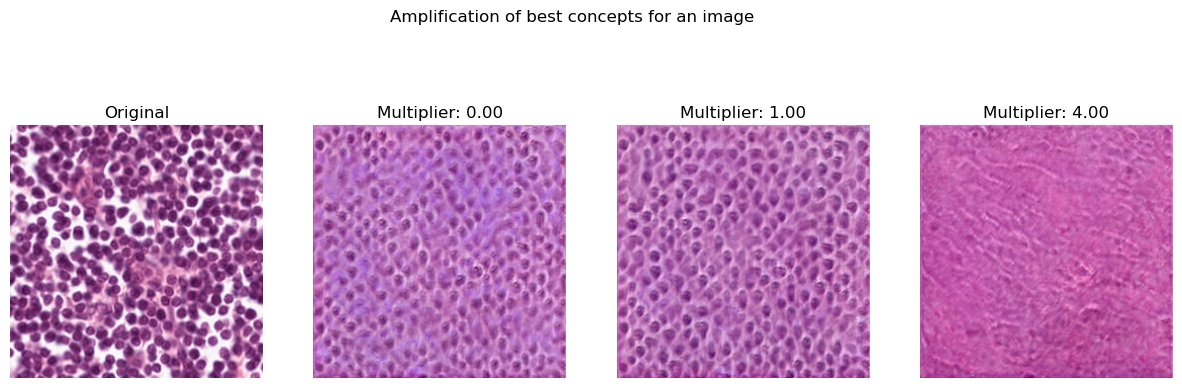

In [29]:
plot_amplified_images(results.image, results.amplified_images, results.multipliers)
